## Importing Important Libraries and Dataset

In [157]:
# importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [159]:
# importing the dataset
df = pd.read_csv("//Users//kaustubhgarg//Desktop//AAPL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [161]:
# Getting an idea about null values
df.isnull().sum().any() 

True

In [163]:
# Getting the count of null values
df.isnull().sum() 

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [165]:
# Getting an idea about the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9822 non-null   float64
 2   High       9822 non-null   float64
 3   Low        9822 non-null   float64
 4   Close      9822 non-null   float64
 5   Adj Close  9822 non-null   float64
 6   Volume     9822 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB


In [167]:
# Handling missing values
df = df.dropna()

In [169]:
# Again checking the NULL Values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [171]:
# Checking for duplicate rows
df.duplicated().any()

False

## Feature Selection and Date Conversion

In [173]:
# Converting date column to correct format
df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")

In [175]:
# Again checking the Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9822 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9822 non-null   datetime64[ns]
 1   Open       9822 non-null   float64       
 2   High       9822 non-null   float64       
 3   Low        9822 non-null   float64       
 4   Close      9822 non-null   float64       
 5   Adj Close  9822 non-null   float64       
 6   Volume     9822 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 613.9 KB


In [177]:
# Setting the Date as index
df.set_index('Date', inplace = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [179]:
# Use the 'Adj Close' column as the target variable
df = df[['Adj Close']]

## Scaling the Data

In [181]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming you have a pandas DataFrame 'df' with a column 'adjusted_close' for the stock price
# Example: df = pd.read_csv('your_data.csv')

scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
scaled_close = scaler.fit_transform(df['Adj Close'].values.reshape(-1, 1))



## Creating Time Series Sequences

In [187]:
# Function to create sequences for multi-step forecasting
def create_sequences_multi_step(data, time_steps=60, forecast_horizon=[1, 5, 10]):
    X, y = [], []
    for i in range(len(data) - time_steps - max(forecast_horizon)):
        X.append(data[i:(i + time_steps)])
        y.append([data[i + time_steps + h - 1] for h in forecast_horizon])
    return np.array(X), np.array(y)

# Example usage (assuming `scaled_close` is your normalized adjusted close price array)
forecast_horizon = [1, 5, 10]
X, y = create_sequences_multi_step(scaled_close, time_steps=60, forecast_horizon=forecast_horizon)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input for RNN (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Building Simple RNN model

In [189]:


# Function to create Simple RNN model for multi-step forecasting
def create_simple_rnn_model(units=50, dropout_rate=0.4, optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dense(units=3))  # Predicting 3 values (1-day, 5-day, 10-day)

    # Compile model with selected optimizer
    if optimizer == 'adam':
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_absolute_error'])
    elif optimizer == 'rmsprop':
        model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

# Early stopping configuration
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Example of how to train the model with early stopping
simple_rnn_model = create_simple_rnn_model(units=50, dropout_rate=0.4, optimizer='adam', learning_rate=0.001)

history = simple_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0282 - val_loss: 0.0598 - val_mean_absolute_error: 0.1717
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3923e-04 - mean_absolute_error: 0.0075 - val_loss: 0.0363 - val_mean_absolute_error: 0.1239
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3268e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0280 - val_mean_absolute_error: 0.1074
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0088e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0261 - val_mean_absolute_error: 0.1028
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8513e-05 - mean_absolute_error: 0.0058 - val_loss: 0.0270 - val_mean_absolute_error: 0.1077
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2614e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0263 - val_mean_absolute_error: 0.1088
Epoch 7/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.5462e-05 - mean_ab

In [191]:
# Evaluate the model using the test data (same metrics)
test_loss, test_mae = simple_rnn_model.evaluate(X_test, y_test)

# Print the Test Loss (Mean Squared Error) and MAE (Mean Absolute Error)
print(f"Test Loss (Mean Squared Error): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Predict on test data
y_pred = simple_rnn_model.predict(X_test)

# Flatten y_test to match the shape of y_pred
y_test_flat = y_test.reshape(-1, 3)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(np.square(y_test_flat - y_pred)))
print(f"Root Mean Squared Error (RMSE): {rmse}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mean_absolute_error: 0.0328    
Test Loss (Mean Squared Error): 0.022892409935593605
Test Mean Absolute Error (MAE): 0.09772970527410507
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Root Mean Squared Error (RMSE): 0.15130239046864388


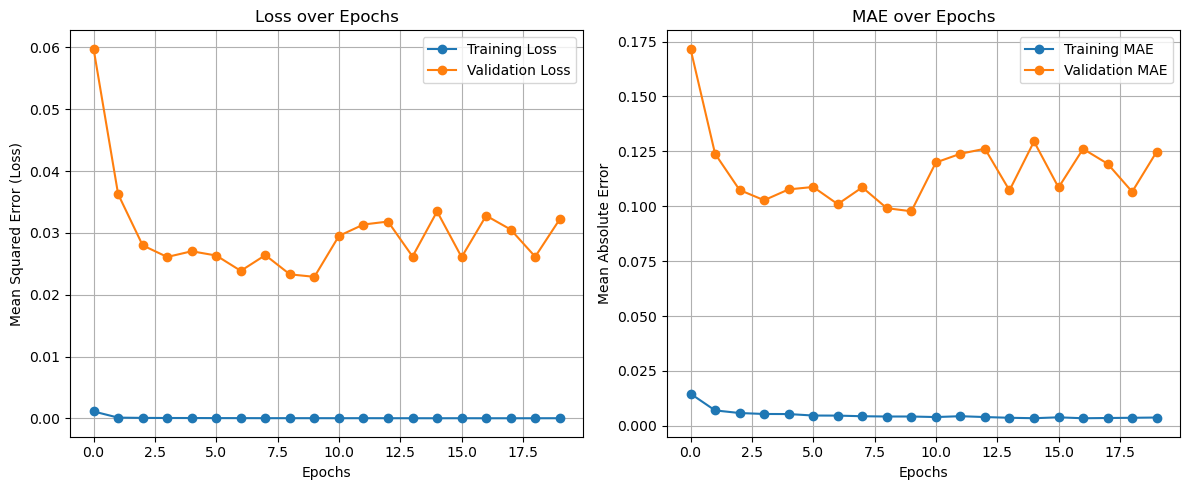

In [195]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE', marker='o')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', marker='o')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Hyperparameter Tuning using Randomised Search CV

In [197]:
import random
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Function to create the Simple RNN model
def create_simple_rnn_model(units=50, dropout_rate=0.4, optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dense(units=3))  # Predicting 3 values (1-day, 5-day, 10-day)

    if optimizer == 'adam':
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_absolute_error'])
    elif optimizer == 'rmsprop':
        model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

# Define the parameter grid
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.0005, 0.001],
    'batch_size': [32, 64]
}

# Function to perform randomized search
def randomized_search(param_grid, n_iter=5):
    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    random_combos = []

    # Generate random combinations of hyperparameters
    keys = list(param_grid.keys())
    for _ in range(n_iter):
        combo = {key: random.choice(param_grid[key]) for key in keys}
        random_combos.append(combo)

    # Run training for each random combination
    for i, params in enumerate(random_combos):
        print(f"Training model {i+1} with params: {params}")

        # Create the model
        model = create_simple_rnn_model(
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer'],
            learning_rate=params['learning_rate']
        )

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30,
            batch_size=params['batch_size'],
            callbacks=[early_stopping],
            verbose=0
        )

        # Track the validation loss
        val_loss = min(history.history['val_loss'])

        # Save the best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = params

    return best_model, best_params

# Perform Randomized Search
best_model, best_params = randomized_search(param_grid, n_iter=5)

# Output the best model parameters
print("\nBest Model Params:", best_params)

Training model 1 with params: {'units': 50, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'batch_size': 32}
Training model 2 with params: {'units': 50, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'batch_size': 32}
Training model 3 with params: {'units': 100, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32}
Training model 4 with params: {'units': 100, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0005, 'batch_size': 32}
Training model 5 with params: {'units': 50, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.0005, 'batch_size': 32}

Best Model Params: {'units': 100, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32}


In [199]:
# Train the best model on the full training data
print(f"Training the best model with the following parameters: {best_params}")
model = create_simple_rnn_model(
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    optimizer=best_params['optimizer'],
    learning_rate=best_params['learning_rate']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the best model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

Training the best model with the following parameters: {'units': 100, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0052 - mean_absolute_error: 0.0344 - val_loss: 0.0334 - val_mean_absolute_error: 0.1227
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6146e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0175 - val_mean_absolute_error: 0.0872
Epoch 3/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0390e-04 - mean_absolute_error: 0.0073 - val_loss: 0.0124 - val_mean_absolute_error: 0.0766
Epoch 4/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.4926e-05 - mean_absolute_error: 0.0062 - val_loss: 0.0103 - val_mean_absolute_error: 0.0692
Epoch 5/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.0459e-05 - mean_absolute_error: 0.0059 - val_loss: 0.0080 - val_mean_absolute_error: 0.0577
Epoch 6/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.0899e-05 - m

In [201]:
# Evaluate the best model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions with the best model
y_pred = model.predict(X_test)

# Flatten y_test and y_pred to calculate RMSE
y_test_flat = y_test.reshape(-1, 3)
rmse = np.sqrt(np.mean(np.square(y_test_flat - y_pred)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0228    
Test Loss: 0.005837747827172279
Test MAE: 0.05153623968362808
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Root Mean Squared Error (RMSE): 0.07640514647129883


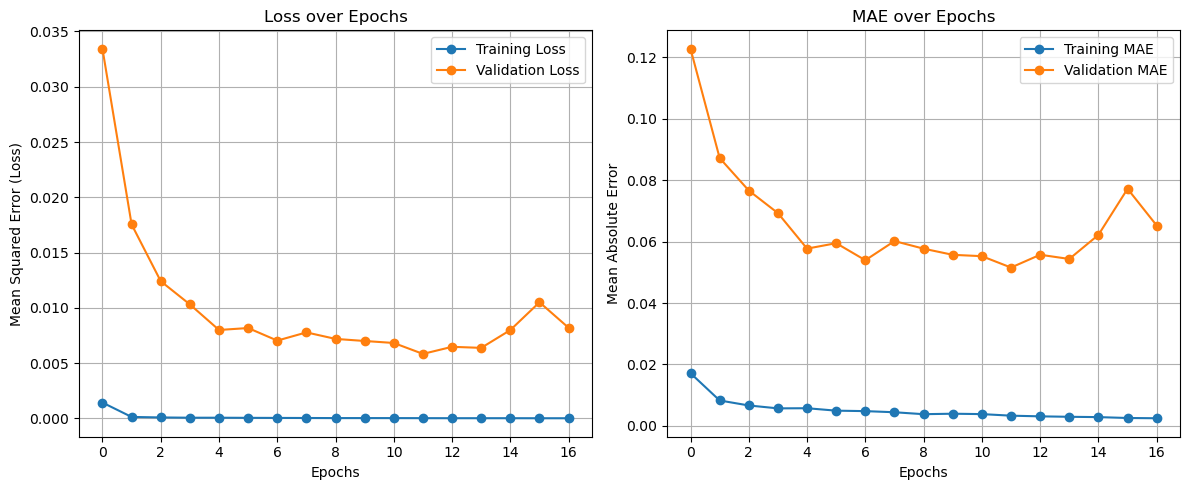

In [203]:
# Plotting training and validation loss for Best Model from Randomized Search
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE', marker='o')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', marker='o')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
'''
conclusions:
1. Best Model (via Randomized Search) performs best across all metrics, with the lowest loss, MAE, and RMSE, and shows no 
significant overfitting.

2. Tuned Model has a lower performance than the best model, and its validation loss suggests potential overfitting.

3. The Untuned Model shows the highest test loss, MAE, and RMSE, meaning it has the worst performance overall.
'''

## Creating LSTM model

In [78]:


# Function to create a simple LSTM model
def create_lstm_model():
    model = Sequential()

    # First LSTM layer with 'units' neurons and return_sequences=True
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

    # Dropout layer to prevent overfitting
    model.add(Dropout(0.4))

    # Second LSTM layer (return_sequences=False means output a single vector)
    model.add(LSTM(units=50, return_sequences=False))

    # Output layer with three neurons for multi-step prediction (1-day, 5-day, 10-day)
    model.add(Dense(units=3))  # 3 outputs for 1-day, 5-day, and 10-day predictions

    # Compile the model using Adam optimizer and Mean Squared Error loss
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

# Ensure X_train is reshaped for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create the model
lstm_model = create_lstm_model()

# Early stopping to prevent overfitting (monitor validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping], verbose=1
)


Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.6122e-04 - mean_absolute_error: 0.0071 - val_loss: 0.0013 - val_mean_absolute_error: 0.0244
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.9057e-05 - mean_absolute_error: 0.0026 - val_loss: 0.0011 - val_mean_absolute_error: 0.0235
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.6743e-05 - mean_absolute_error: 0.0024 - val_loss: 8.9294e-04 - val_mean_absolute_error: 0.0216
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.5195e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0012 - val_mean_absolute_error: 0.0236
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.4539e-05 - mean_absolute_error: 0.0022 - val_loss: 8.2753e-04 - val_mean_absolute_error: 0.0202
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.3792e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0017 - val_mean_absolute_error: 0.0284
Epoch 7/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1

In [82]:
# Evaluate the model using the test data
test_loss, test_mae = lstm_model.evaluate(X_test, y_test)

# Print test performance metrics
print(f"Test Loss (Mean Squared Error): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Make predictions on the test data
y_pred = lstm_model.predict(X_test)

# Flatten y_test and y_pred to calculate RMSE
y_test_flat = y_test.reshape(-1, 3)
rmse = np.sqrt(np.mean(np.square(y_test_flat - y_pred)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4504e-04 - mean_absolute_error: 0.0140
Test Loss (Mean Squared Error): 0.0008275298168882728
Test Mean Absolute Error (MAE): 0.020188329741358757
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Root Mean Squared Error (RMSE): 0.0287668198507099


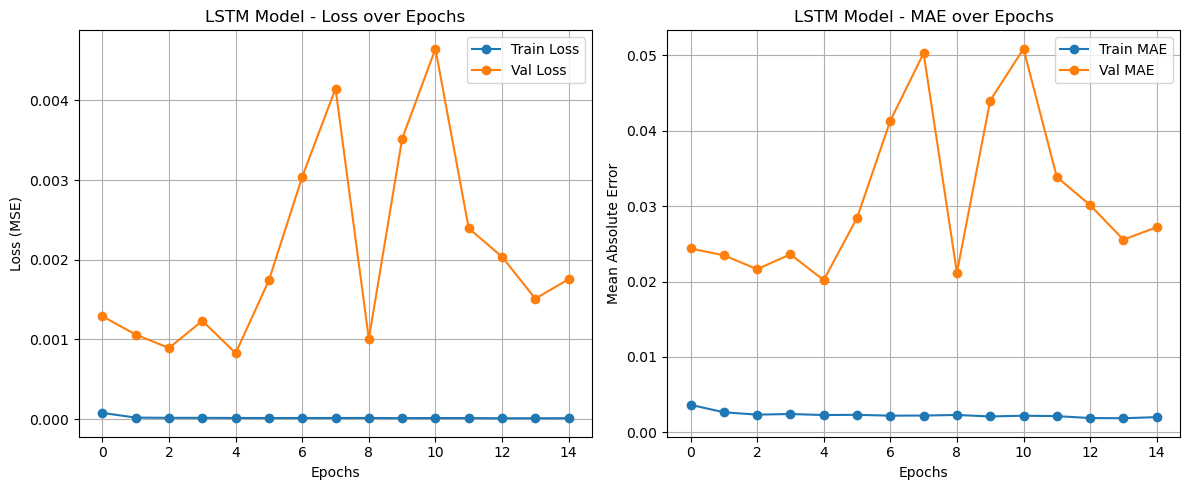

In [84]:
# Plot loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker = 'o')
plt.plot(history.history['val_loss'], label='Val Loss',marker = 'o')
plt.title('LSTM Model - Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE',marker = 'o')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE',marker = 'o')
plt.title('LSTM Model - MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Hyperparameter Optimisation in LSTM using RandomisedSearch Cv

In [107]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Function to create the LSTM model with hyperparameters
def create_lstm_model(units=50, dropout_rate=0.3, optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))  # Added second Dropout for better regularization
    model.add(Dense(1))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Hyperparameter grid
param_grid = {
    'units': [50],  # Less complex, faster
    'dropout_rate': [0.4, 0.5],  # Stronger regularization
    'optimizer': ['adam'],  # Adam is usually faster + better
    'learning_rate': [0.0005],  # Slower learning, helps generalize
    'batch_size': [64]  # Larger batch = faster training per epoch
}

# Random search configuration
n_trials = 30
best_score = float('inf')
best_params = None

print(" Starting Random Search for Hyperparameters...\n")

for _ in range(n_trials):
    # Randomly select hyperparameters
    units = random.choice(param_grid['units'])
    dropout_rate = random.choice(param_grid['dropout_rate'])
    optimizer = random.choice(param_grid['optimizer'])
    learning_rate = random.choice(param_grid['learning_rate'])
    batch_size = random.choice(param_grid['batch_size'])

    print(f"Training: units={units}, dropout={dropout_rate}, optimizer={optimizer}, "
          f"lr={learning_rate}, batch={batch_size}")

    model = create_lstm_model(units, dropout_rate, optimizer, learning_rate)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=15,  # Reduced epochs
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    val_loss = min(history.history['val_loss'])

    if val_loss < best_score:
        best_score = val_loss
        best_params = {
            'units': units,
            'dropout_rate': dropout_rate,
            'optimizer': optimizer,
            'learning_rate': learning_rate,
            'batch_size': batch_size
        }

# Show best parameters
print("\n Best Hyperparameters Found:")
print(best_params)
print(f" Best Validation Loss: {best_score:.6f}")


 Starting Random Search for Hyperparameters...

Training: units=50, dropout=0.5, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.5, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.5, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.5, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.5, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.5, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0005, batch=64
Training: units=50, dropout=0.4, optimizer=adam, lr=0.0

In [109]:
# Final training with best hyperparameters
final_model = create_lstm_model(
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    optimizer=best_params['optimizer'],
    learning_rate=best_params['learning_rate']
)

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.7838e-04 - mean_absolute_error: 0.0103 - val_loss: 0.0018 - val_mean_absolute_error: 0.0330
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.4968e-05 - mean_absolute_error: 0.0043 - val_loss: 6.6497e-04 - val_mean_absolute_error: 0.0183
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.3452e-05 - mean_absolute_error: 0.0036 - val_loss: 6.3567e-04 - val_mean_absolute_error: 0.0179
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.1990e-05 - mean_absolute_error: 0.0039 - val_loss: 6.3419e-04 - val_mean_absolute_error: 0.0179
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.1731e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0014 - val_mean_absolute_error: 0.0295
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.5828e-05 - mean_absolute_error: 0.0037 - val_loss: 9.5430e-04 - val_mean_absolute_error: 0.0232
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step -

In [111]:
# Evaluate on test set
test_loss, test_mae = final_lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict
y_pred = final_lstm_model.predict(X_test)

# Flatten y_test and y_pred to calculate RMSE
y_test_flat = y_test.reshape(-1, 3)
rmse = np.sqrt(np.mean(np.square(y_test_flat - y_pred)))
print(f"Root Mean Squared Error (RMSE): {rmse}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9265e-04 - mean_absolute_error: 0.0101
Test Loss: 0.0003929986269213259
Test MAE: 0.013554777018725872
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Root Mean Squared Error (RMSE): 0.019824194058721697


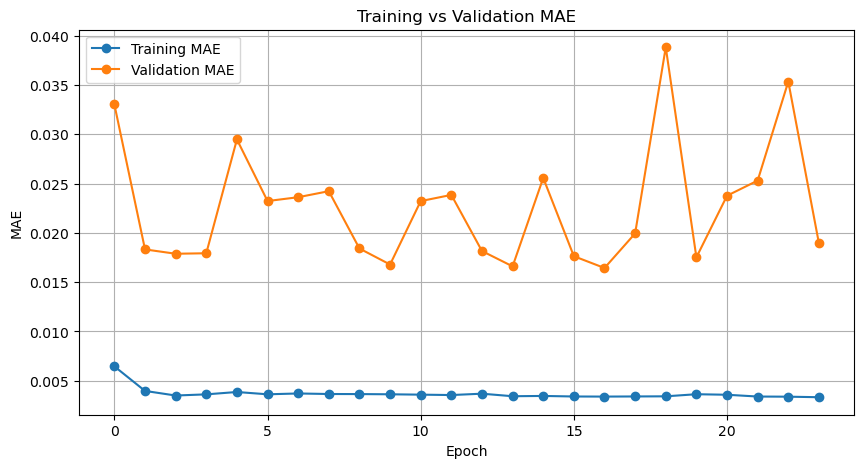

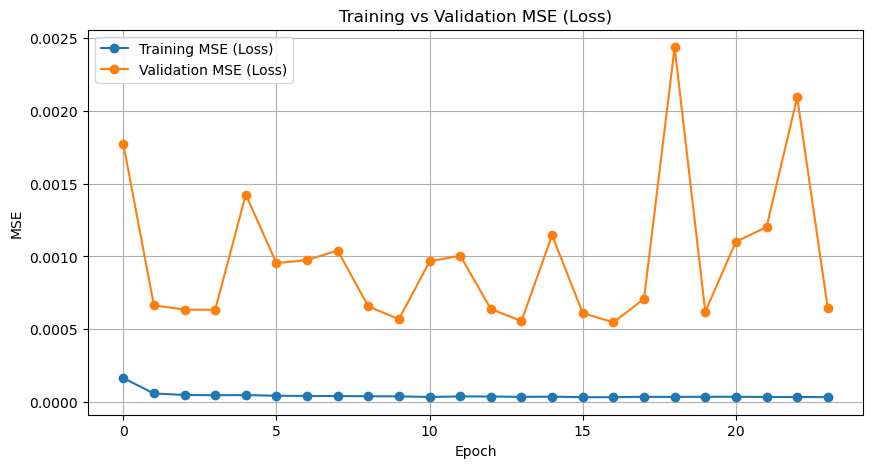

In [113]:
import matplotlib.pyplot as plt

# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_absolute_error'], label='Training MAE', marker = 'o')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', marker = 'o')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE (based on 'loss' and 'val_loss' since MSE is used as the loss function)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training MSE (Loss)', marker = 'o')
plt.plot(history.history['val_loss'], label='Validation MSE (Loss)', marker = 'o')
plt.title('Training vs Validation MSE (Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
'''
Conclusions:
1. The second model (after hyperparameter tuning) is performing better in terms of loss, MAE, and RMSE.
2. There is no clear sign of overfitting as both the test and validation losses are quite low and similar in both models.
The use of early stopping likely helped prevent overfitting by ensuring the model didn't train too long without improvement.
'''

In [ ]:
'''
Conclusions:
1. Tuned LSTM Model performs better than the Tuned SimpleRNN Model across all metrics (Test Loss, Test MAE, and RMSE), 
suggesting that the LSTM model is more suited for time-series prediction tasks in this context.
2. The SimpleRNN Model shows signs of higher prediction errors, as reflected by the higher loss, MAE, and RMSE values.
'''